# Functions and import

In [1]:
import sqlalchemy
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from IPython.display import display, HTML
from IPython.display import Image
import seaborn as sns
import csv
from dython import nominal
from scipy.stats import chi2_contingency
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder,OrdinalEncoder
from tabulate import tabulate
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn import model_selection, metrics
from xgboost import XGBClassifier
import scikitplot as skplt
from mlxtend.evaluate import lift_score
from sklearn.metrics import make_scorer,RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mixed_naive_bayes import MixedNB
from sklearn.inspection import permutation_importance
import kds
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.pipeline import Pipeline, make_pipeline
from skopt import BayesSearchCV
from sklearn.compose import make_column_transformer



def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.display.max_columns = None
jupyter_settings()


def boxplot_analysis_quantitative(df,nrows,ncols):
    fig, axs = plt.subplots(nrows, ncols)
    plt.tight_layout()
    plt.show()
    
    for column,axis in zip(df.select_dtypes(exclude=[object]).columns, axs.flatten() ):
        sns.boxplot(data=df.select_dtypes(exclude=[object]), y=column, ax=axis)
        axis.tick_params(axis='y', labelsize=15)
        axis.yaxis.label.set_fontsize(15)
        
def data_description(df):
    print('Variables:\n\n{}'.format(df.dtypes), end='\n\n')
    print('Number of rows {}'.format(df.shape[0]), end='\n\n')
    print('Number of columns {}'.format(df.shape[1]), end='\n\n')
    print('NA analysis'.format(end='\n') )
    for i in df.columns:
        print('column {}: {} {}'.format(i,df[i].isna().any(), df[i].isna().sum() ) )
    print('Unique values for each columns'.format(end='\n') )
    for i in df.columns:
        print('column {}: {}'.format(i,df[i].unique() ) )
        
lift_scorer = make_scorer(lift_score)


def precision_at_k(data, k=2000, proba=0):
    
    # create and sorte score by probability
    data['score'] = proba[:,1].tolist()
    data = data.sort_values(by='score', ascending=False)
    
    #reset index
    data= data.reset_index(drop=True) 
    
    #Create ranking order
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k=2000, proba = 0):
    
    # create and sorte score by probability
    data['score'] = proba[:,1].tolist()
    data = data.sort_values(by='score', ascending=False)
    
    #reset index
    data= data.reset_index(drop=True) 
    
    #create ranking order
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k,'recall_at_k']

# Loading Data 

In [2]:
df_raw = pd.read_csv('train.csv')

# Data Description

In [3]:
df1 = df_raw.copy()

In [5]:
df1.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,2577.05,24196.90,104.31,31.04,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.87,2465.39,19227.38,69.86,36.92,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.64,1055.29,42822.28,134.20,34.56,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.14,703.05,51786.83,297.35,31.49,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.72,891.29,44626.85,134.20,28.03,2,8,7,24,10,8,20,Sim,Não,Negar


In [6]:
data_description(df1)

Variables:

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

Number of rows 9500

Number of columns 17

NA analysis
column id_cliente: False 0
column idade: False 0
column saldo_atual: False 0
column divida_atual: False 0
column renda_anual: False 0
column valor_em_investimentos: False 0
column taxa_utilizacao_credito: False 0
column num_emprestimos: False 0
column num_contas_bancarias: False 0
column num_cartoes_credito: False 0
colum

# Data Wrangling

## Descriptive statistics

In [7]:
df1.describe(include=['float64','int64'] ).T

,count,mean,std,min,25%,50%,75%,max
id_cliente,9500.00,6210.53,3603.24,1.00,3091.75,6172.50,9320.25,12500.00
idade,9500.00,126.40,685.04,18.00,28.00,38.00,47.00,8598.00
saldo_atual,9500.00,404.53,217.70,0.09,272.36,337.17,471.26,1602.04
divida_atual,9500.00,1437.09,1156.26,0.23,573.62,1175.73,1963.33,4998.07
renda_anual,9500.00,195037.27,1454273.73,10473.87,26207.90,45991.11,80449.83,23279657.98
valor_em_investimentos,9500.00,612.00,2002.44,0.00,76.08,134.20,249.18,10000.00
taxa_utilizacao_credito,9500.00,32.27,5.11,20.99,28.08,32.26,36.46,49.56
num_emprestimos,9500.00,10.86,62.56,0.00,2.00,3.00,6.00,1496.00
num_contas_bancarias,9500.00,17.55,120.98,0.00,3.00,6.00,7.00,1779.00
num_cartoes_credito,9500.00,21.43,122.68,1.00,4.00,6.00,7.00,1479.00


## Replace outliers

In [4]:
df1['idade'] = np.where(df1['idade'] > 90, 38,df1['idade'] )
df1['num_emprestimos'] = np.where(df1['num_emprestimos'] > 20, 3,df1['num_emprestimos'] )
df1['num_contas_bancarias'] = np.where(df1['num_contas_bancarias'] > 40, 6,df1['num_contas_bancarias'] )
df1['num_cartoes_credito'] = np.where(df1['num_cartoes_credito'] > 40, 5,df1['num_cartoes_credito'] )
df1['num_pgtos_atrasados'] = np.where(df1['num_pgtos_atrasados'] > 30, 14,df1['num_pgtos_atrasados'] )
df1['num_consultas_credito'] = np.where(df1['num_consultas_credito'] > 50, 4,df1['num_consultas_credito'] )
df1['taxa_juros'] = np.where(df1['taxa_juros'] > 40, 13,df1['taxa_juros'] )

In [32]:
df1.describe(include=['float64','int64'] ).T

,count,mean,std,min,25%,50%,75%,max
id_cliente,9500.00,6210.53,3603.24,1.00,3091.75,6172.50,9320.25,12500.00
idade,9500.00,37.69,11.22,18.00,28.00,38.00,46.00,61.00
saldo_atual,9500.00,404.53,217.70,0.09,272.36,337.17,471.26,1602.04
divida_atual,9500.00,1437.09,1156.26,0.23,573.62,1175.73,1963.33,4998.07
renda_anual,9500.00,195037.27,1454273.73,10473.87,26207.90,45991.11,80449.83,23279657.98
valor_em_investimentos,9500.00,612.00,2002.44,0.00,76.08,134.20,249.18,10000.00
taxa_utilizacao_credito,9500.00,32.27,5.11,20.99,28.08,32.26,36.46,49.56
num_emprestimos,9500.00,3.52,2.40,0.00,2.00,3.00,5.00,19.00
num_contas_bancarias,9500.00,5.39,2.64,0.00,3.00,6.00,7.00,40.00
num_cartoes_credito,9500.00,5.54,2.13,1.00,4.00,5.00,7.00,39.00


## Quantitative Analysis

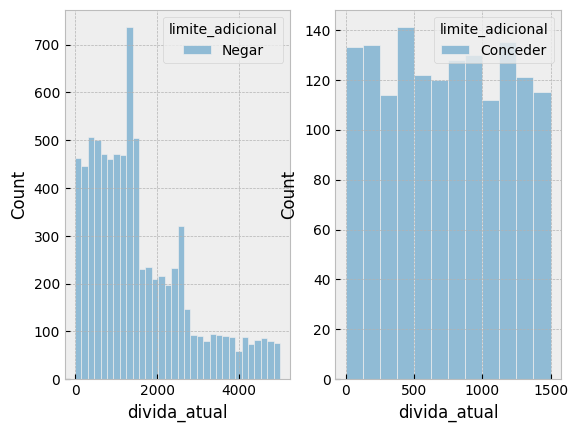

In [4]:
plt.subplot(1,2,1)
sns.histplot(x='divida_atual',data=df1[ (df1['limite_adicional'] == 'Negar') ],hue='limite_adicional', );

plt.subplot(1,2,2)
sns.histplot(x='divida_atual',data=df1[ (df1['limite_adicional'] == 'Conceder') ],hue='limite_adicional');

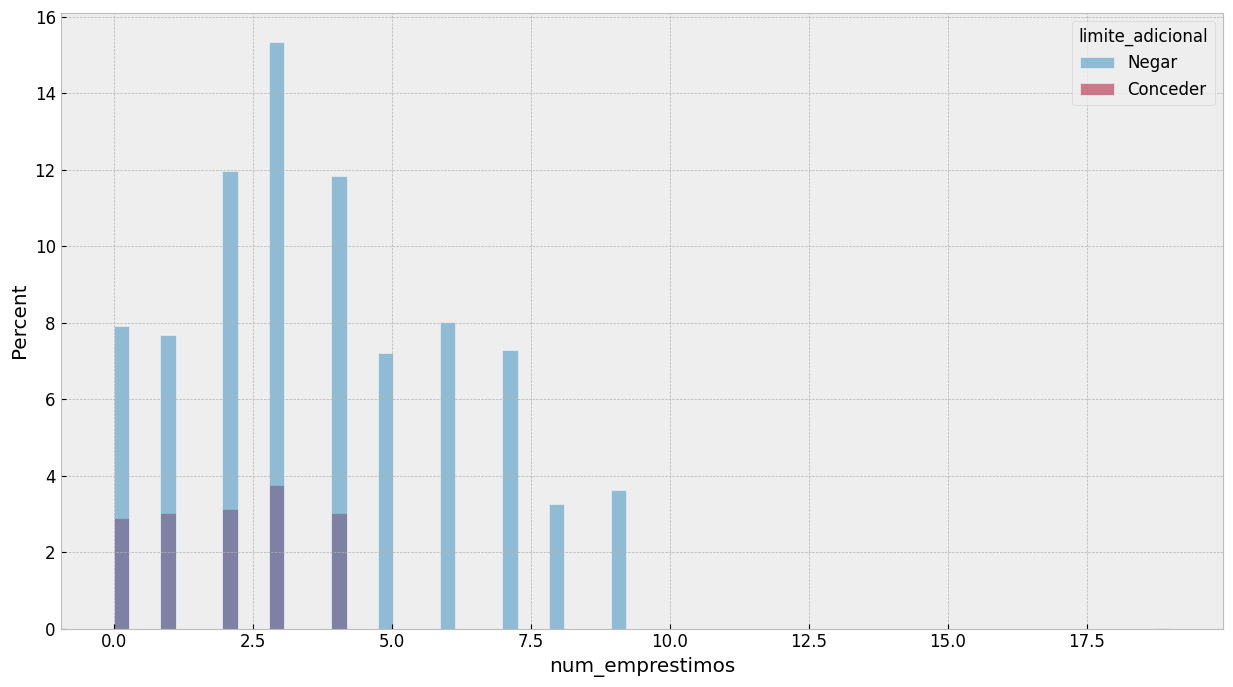

In [433]:
sns.histplot(x='num_emprestimos',data=df1,hue='limite_adicional', stat='percent');


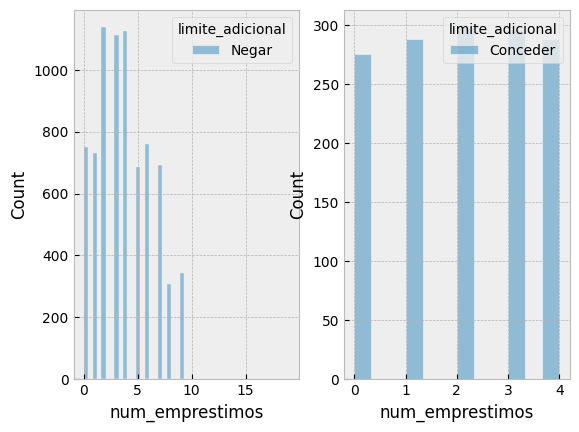

In [35]:
plt.subplot(1,2,1)
sns.histplot(x='num_emprestimos',data=df1[ (df1['limite_adicional'] == 'Negar') & (df1['num_emprestimos'] < 20) ],hue='limite_adicional', );

plt.subplot(1,2,2)
sns.histplot(x='num_emprestimos',data=df1[ (df1['limite_adicional'] == 'Conceder') & (df1['num_emprestimos'] < 20) ],hue='limite_adicional');

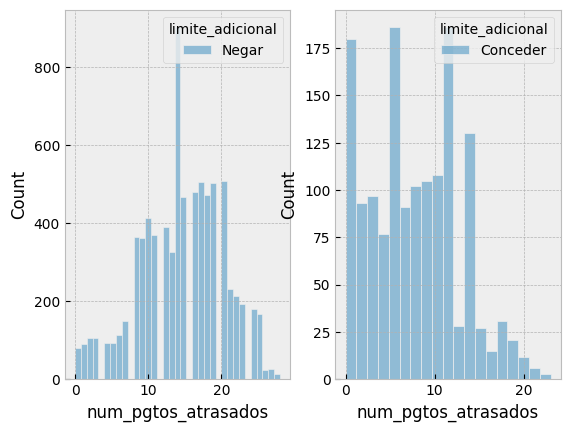

In [13]:
plt.subplot(1,2,1)
sns.histplot(x='num_pgtos_atrasados',data=df1[ (df1['limite_adicional'] == 'Negar') & (df1['num_pgtos_atrasados'] < 30) ],hue='limite_adicional', );

plt.subplot(1,2,2)
sns.histplot(x='num_pgtos_atrasados',data=df1[ (df1['limite_adicional'] == 'Conceder') & (df1['num_pgtos_atrasados'] < 30) ],hue='limite_adicional');

In [ ]:
plt.subplot(1,2,1)
sns.histplot(x='divida_atual',data=df1[ (df1['limite_adicional'] == 'Negar') ],hue='limite_adicional', );

plt.subplot(1,2,2)
sns.histplot(x='divida_atual',data=df1[ (df1['limite_adicional'] == 'Conceder') ],hue='limite_adicional');

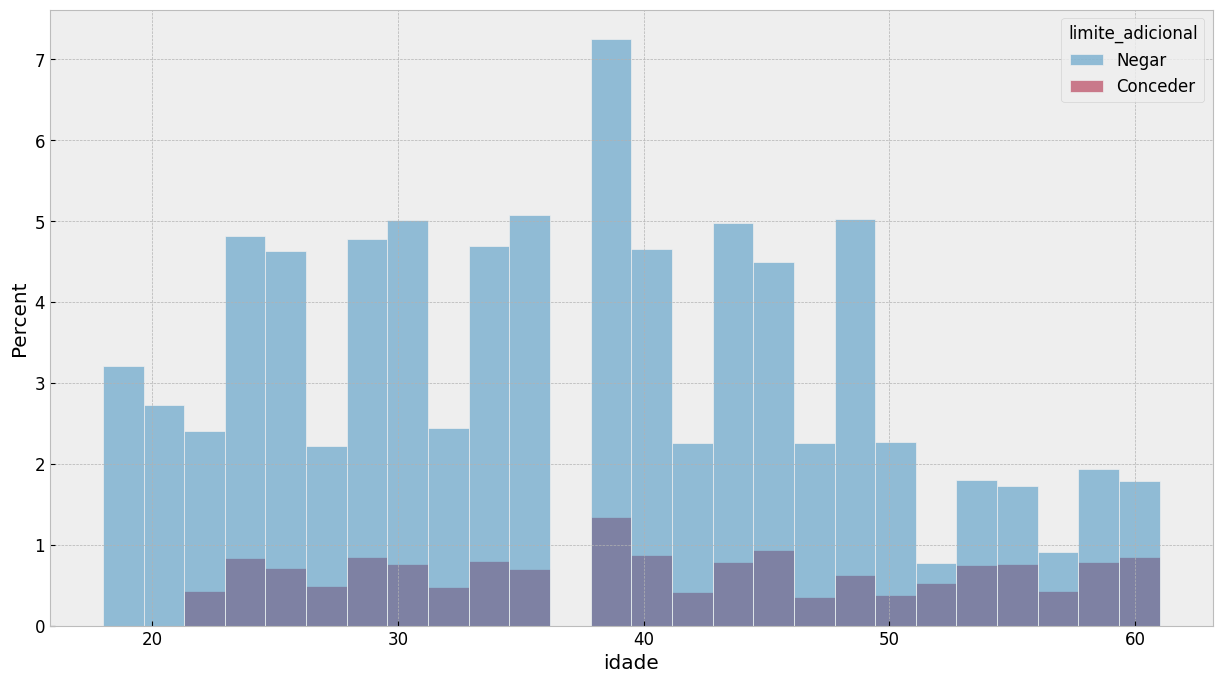

In [416]:
sns.histplot(x='idade',data=df1,hue='limite_adicional', stat='percent');

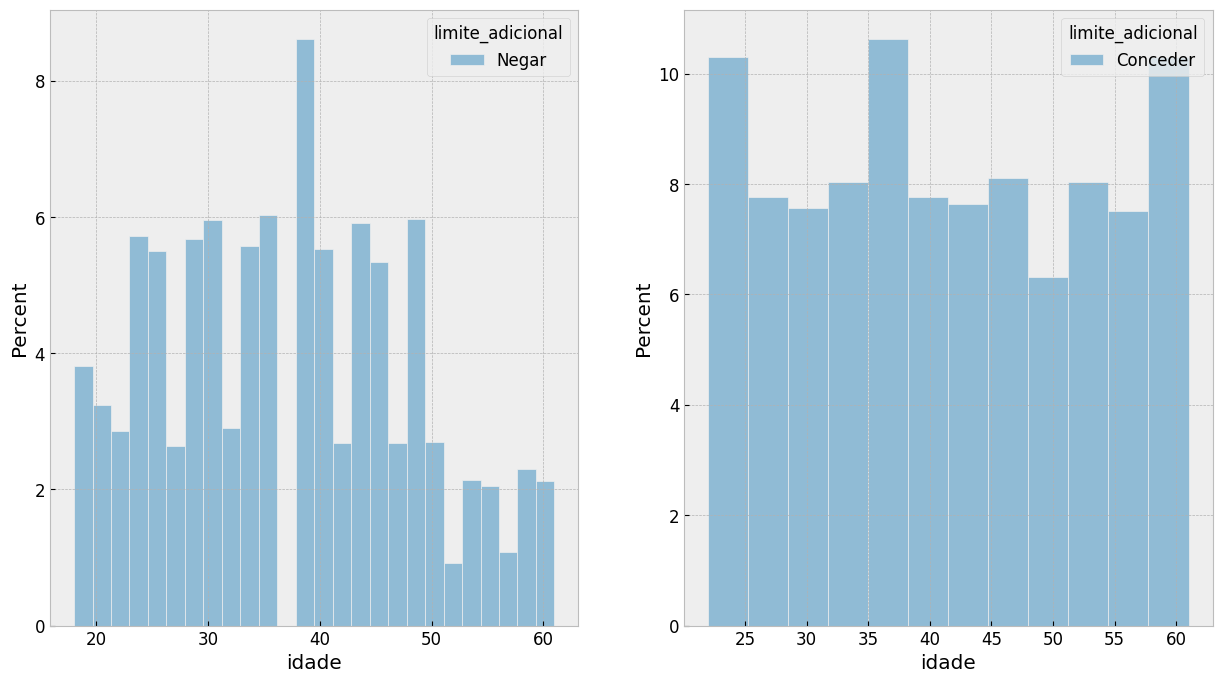

In [411]:
plt.subplot(1,2,1)
sns.histplot(x='idade',data=df1[ (df1['limite_adicional'] == 'Negar')],hue='limite_adicional', stat='percent');

plt.subplot(1,2,2)
sns.histplot(x='idade',data=df1[ (df1['limite_adicional'] == 'Conceder') ],hue='limite_adicional', stat='percent');

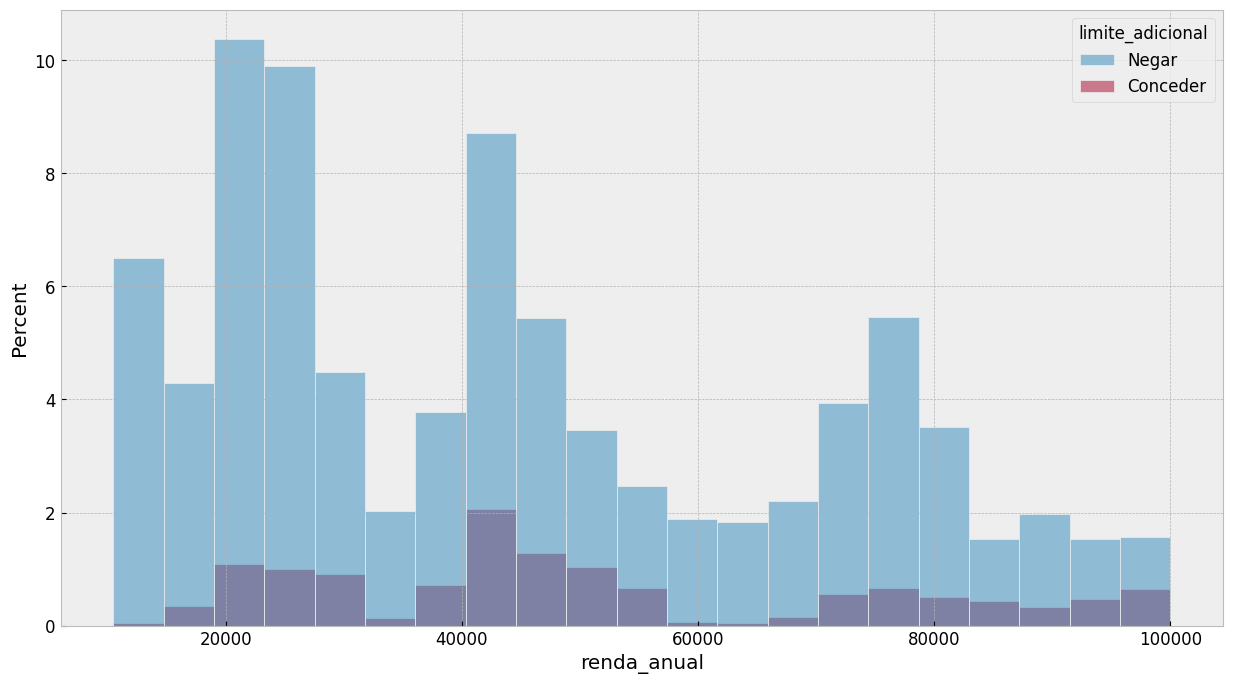

In [414]:
sns.histplot(x='renda_anual',data=df1[df1['renda_anual'] < 100000],hue='limite_adicional', stat='percent');


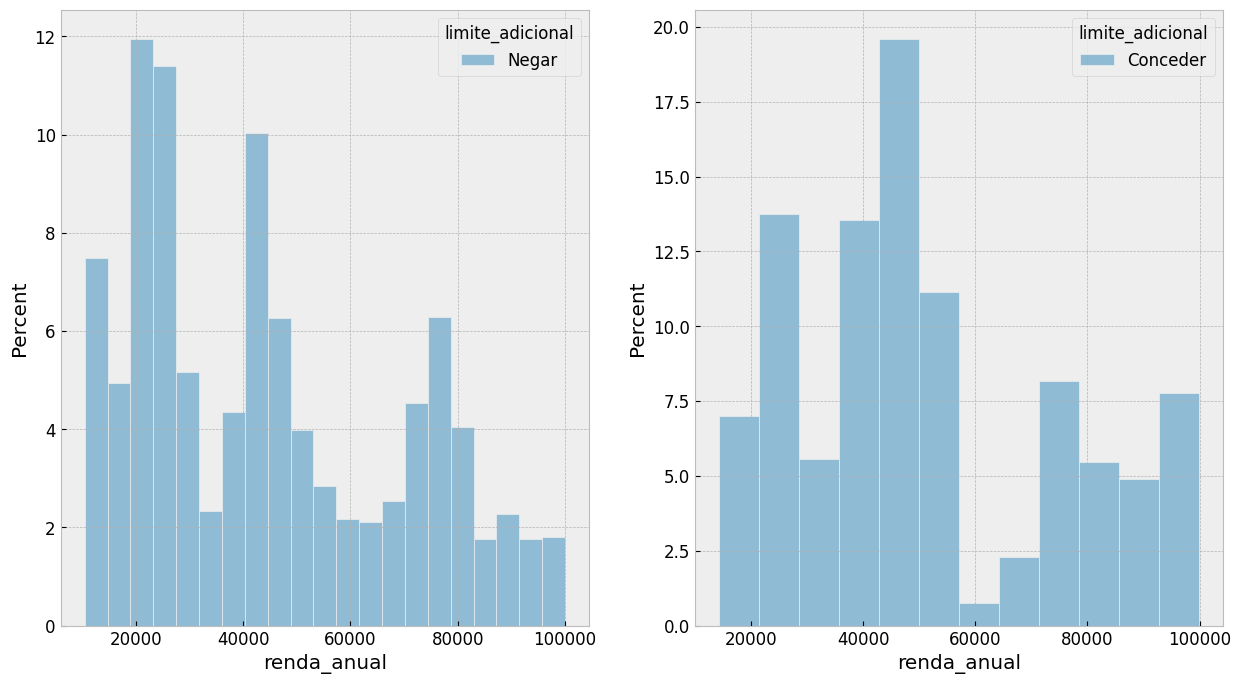

In [412]:
plt.subplot(1,2,1)
sns.histplot(x='renda_anual',data=df1[ (df1['limite_adicional'] == 'Negar') & (df1['renda_anual'] < 100000) ],hue='limite_adicional',
            stat='percent');

plt.subplot(1,2,2)
sns.histplot(x='renda_anual',data=df1[ (df1['limite_adicional'] == 'Conceder') & ((df1['renda_anual'] < 100000) ) ],
             hue='limite_adicional', stat='percent');

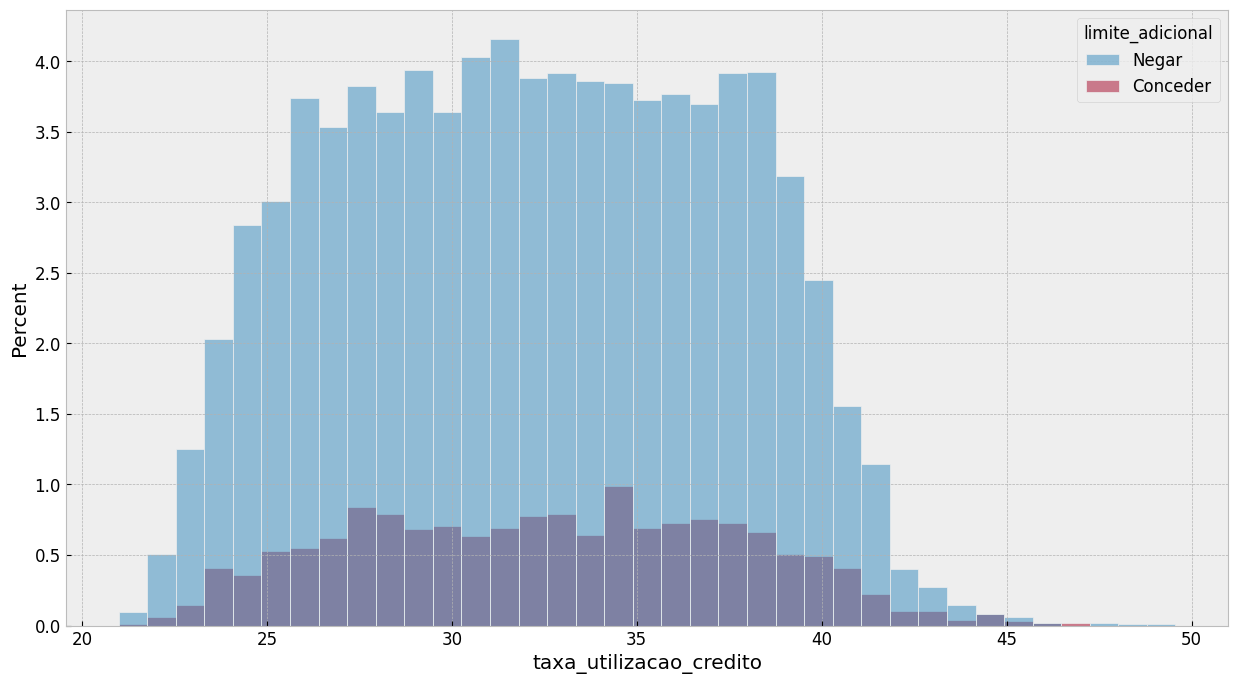

In [429]:
sns.histplot(x='taxa_utilizacao_credito',data=df1,hue='limite_adicional', stat='percent');


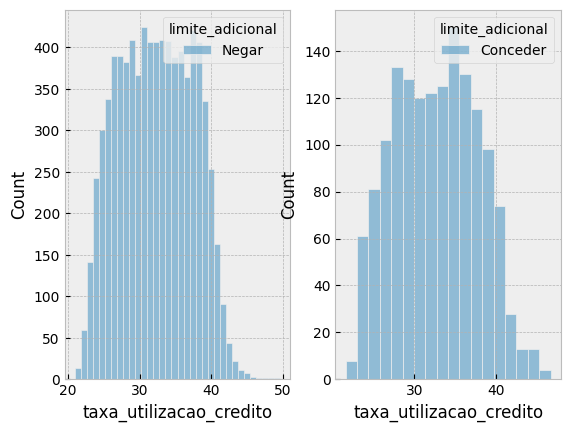

In [9]:
plt.subplot(1,2,1)
sns.histplot(x='taxa_utilizacao_credito',data=df1[ (df1['limite_adicional'] == 'Negar') ],hue='limite_adicional', );

plt.subplot(1,2,2)
sns.histplot(x='taxa_utilizacao_credito',data=df1[ (df1['limite_adicional'] == 'Conceder') ],hue='limite_adicional');

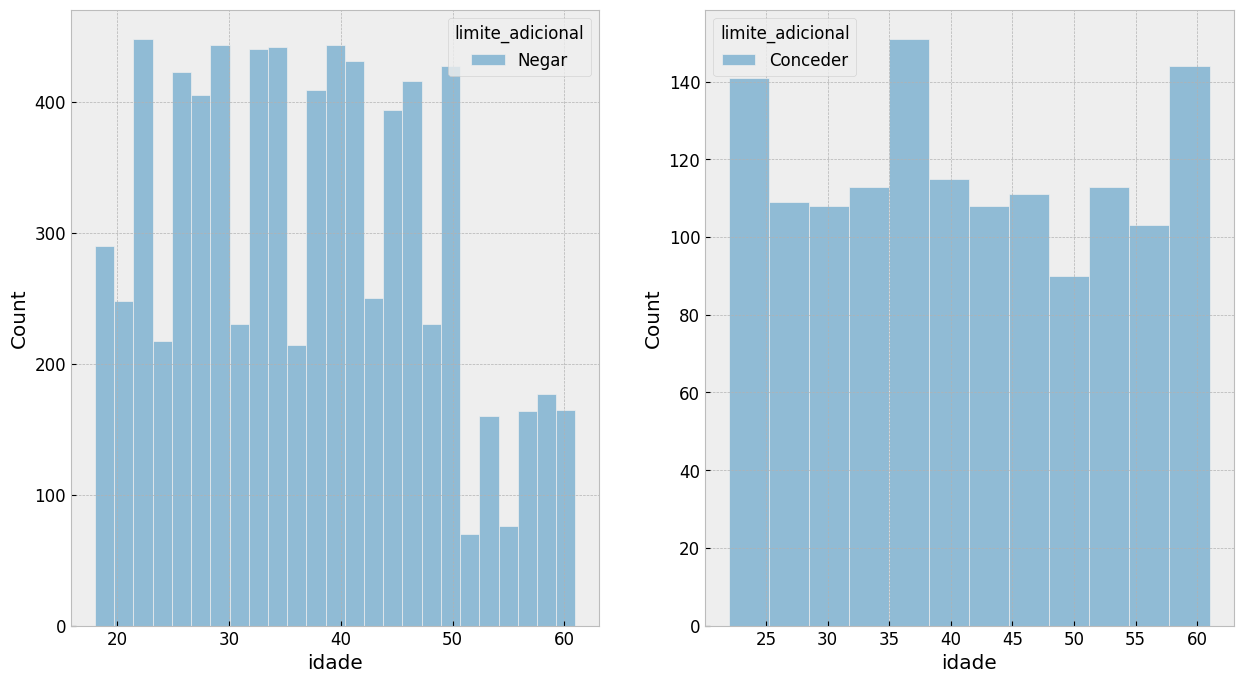

In [403]:
plt.subplot(1,2,1)
sns.histplot(x='idade',data=df1[ (df1['limite_adicional'] == 'Negar') & (df1['valor_em_investimentos'] < 1000) ],hue='limite_adicional', );

plt.subplot(1,2,2)
sns.histplot(x='idade',data=df1[ (df1['limite_adicional'] == 'Conceder') & ((df1['valor_em_investimentos'] < 1000) ) ],hue='limite_adicional');

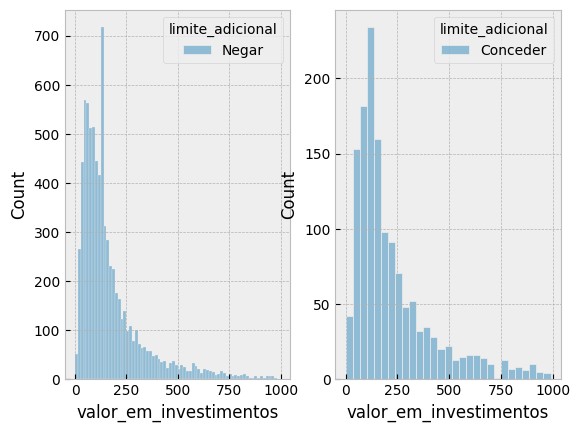

In [8]:
plt.subplot(1,2,1)
sns.histplot(x='valor_em_investimentos',data=df1[ (df1['limite_adicional'] == 'Negar') & (df1['valor_em_investimentos'] < 1000) ],hue='limite_adicional', );

plt.subplot(1,2,2)
sns.histplot(x='valor_em_investimentos',data=df1[ (df1['limite_adicional'] == 'Conceder') & ((df1['valor_em_investimentos'] < 1000) ) ],hue='limite_adicional');

## Categorical Analysis

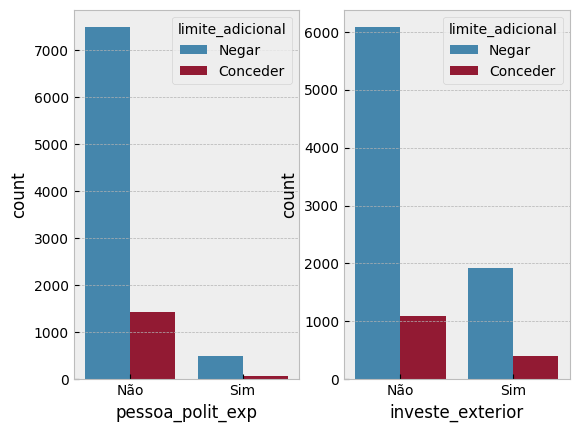

In [34]:
plt.subplot(1,2,1)
sns.countplot(x='pessoa_polit_exp', hue=('limite_adicional'), data=df1);

plt.subplot(1,2,2)
sns.countplot(x='investe_exterior', hue=('limite_adicional'), data=df1);

# Feature engineering

In [4]:
df2 = df1.copy()

# Saldo devedor por dia (divida_atual / dias_atraso_dt_venc)
df2['divida_diaria'] = df2.apply(lambda x: x['divida_atual'] / x['dias_atraso_dt_venc'] if x['dias_atraso_dt_venc'] > 0 else 0, axis=1)

# Colocar dias de atraso menor que zero ser igual a 0.
df2['dias_atraso_dt_venc'] = df2['dias_atraso_dt_venc'].apply(lambda x: 0 if x < 0 else x)

# Liquidez (saldo_atual menos divida_atual)
df2['liquidez'] = df2.apply(lambda x: (x['divida_atual'] / x['saldo_atual']) * 100, axis=1)


# Esforço (divida atual / renda anual) Em percentual
df2['esforco'] = df2.apply(lambda x: (x['divida_atual'] / x['renda_anual']) * 100, axis=1)

#idade
df2['idade'] = df2['idade'].apply(lambda x: 'menor que 25' if x < 25 else 'entre 25 a 40' if 25 < x < 40 
                                 else 'entre 40 a 55' if 40 < x < 55 else 'maior que 55')

#renda anual
df2['renda_anual'] = df2['renda_anual'].apply(lambda x: 'menor que 35000' if x < 35000 else 'entre 35000 e 70000'
                                             if 35000 < x < 70000 else 'entre 70000 a 140000' if 70000 < x < 140000
                                             else 'maior que 140000')


# Empregado (Sim-1 ou Não-0) renda anual igual 0
# R: Não há renda anual igual a zero


# Exploratory Data Analysis

In [5]:
df3 = df2.copy()

## Univariate Analysis

### Response Variable

In [ ]:
df3['id_cliente']

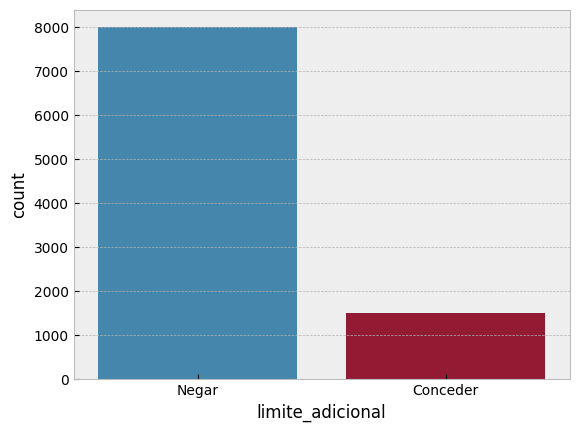

In [39]:
sns.countplot(x=df3['limite_adicional'] );

## Multivariate analysis

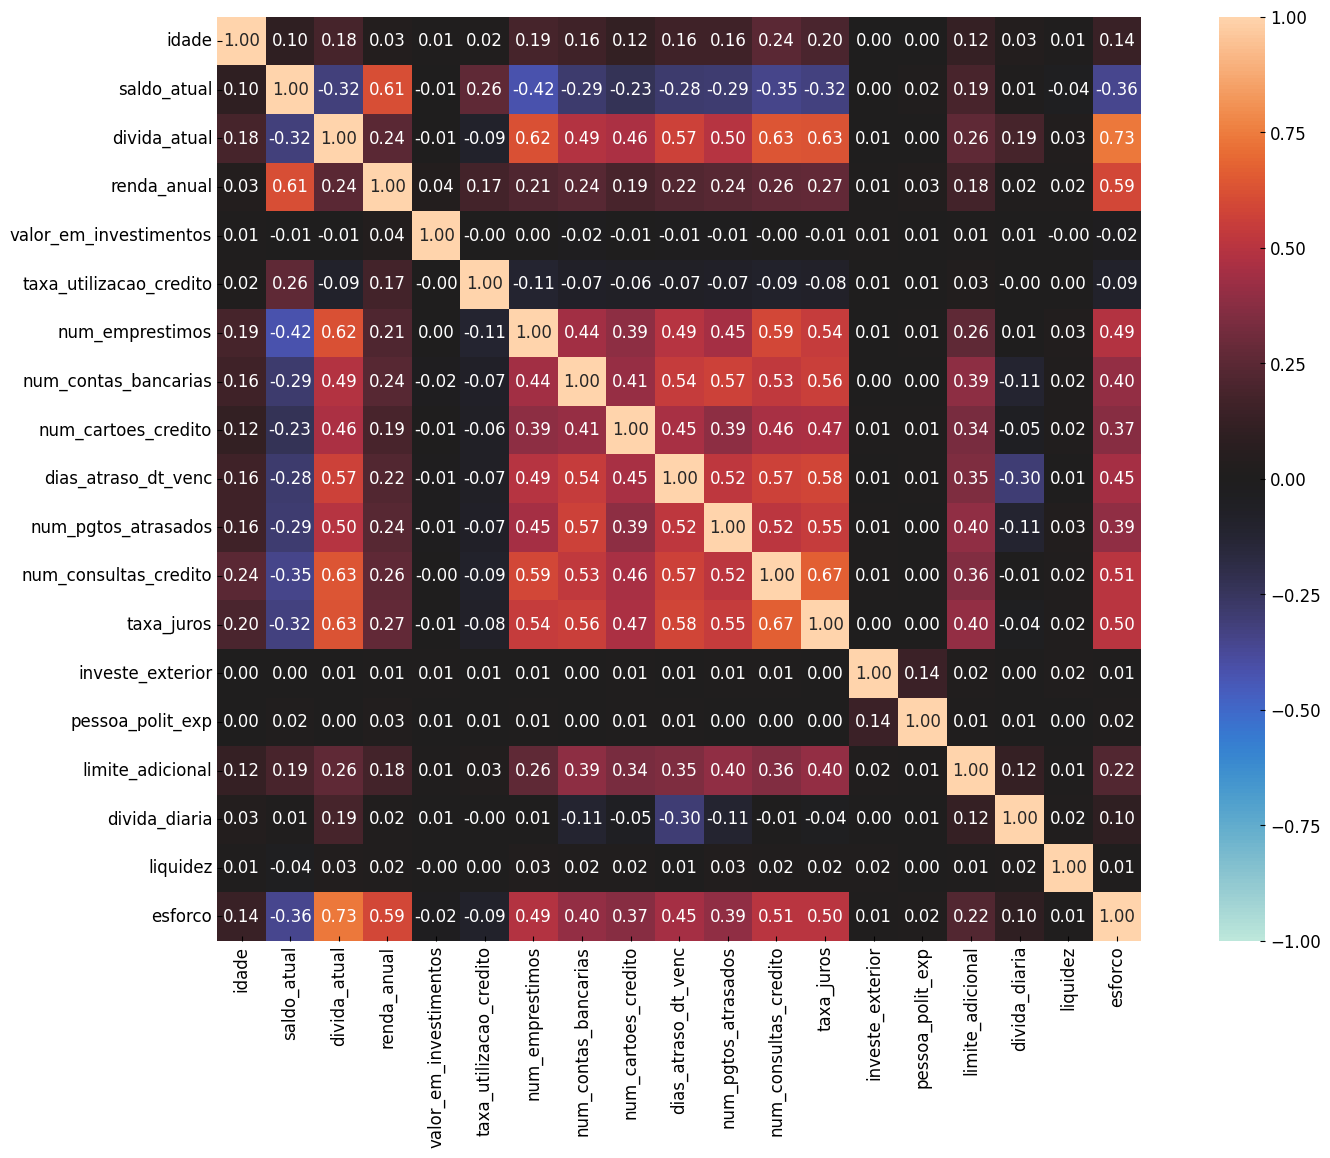

In [11]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['font.size'] = 12
nominal.associations(df3.drop('id_cliente',axis = 1) );

# Data Preparation

In [6]:
df4 = df3.copy()
predictors = df4.drop('limite_adicional', axis=1)
response = df4['limite_adicional']

## Split dataframe into training and test dataset

In [7]:
X_train, X_validation, y_train,y_validation = train_test_split(predictors, response, random_state=42, stratify=response,test_size=.15)
df4 = pd.concat([X_train, y_train], axis=1)

## Transformation

## Rescaling

In [8]:
rs = RobustScaler()
mms = MinMaxScaler()
# annual_premium - RobustScaler
df4['saldo_atual'] = rs.fit_transform(df4[['saldo_atual']].values)
df4['divida_atual'] = rs.fit_transform(df4[['divida_atual']].values)
df4['valor_em_investimentos'] = rs.fit_transform(df4[['valor_em_investimentos']].values)
df4['taxa_utilizacao_credito'] = rs.fit_transform(df4[['taxa_utilizacao_credito']].values)
df4['num_emprestimos'] = rs.fit_transform(df4[['num_emprestimos']].values)
df4['num_contas_bancarias'] = rs.fit_transform(df4[['num_contas_bancarias']].values)
df4['num_cartoes_credito'] = rs.fit_transform(df4[['num_cartoes_credito']].values)
df4['dias_atraso_dt_venc'] = rs.fit_transform(df4[['dias_atraso_dt_venc']].values)
df4['num_pgtos_atrasados'] = rs.fit_transform(df4[['num_pgtos_atrasados']].values)
df4['num_consultas_credito'] = rs.fit_transform(df4[['num_consultas_credito']].values)
df4['taxa_juros'] = rs.fit_transform(df4[['taxa_juros']].values)
df4['esforco'] = rs.fit_transform(df4[['esforco']].values)
df4['liquidez'] = rs.fit_transform(df4[['liquidez']].values)
df4['divida_diaria'] = rs.fit_transform(df4[['divida_diaria']].values)

 ### Encoding

In [9]:
le = LabelEncoder()
ohc = OneHotEncoder()
#Response - Label encoder
y_train = pd.Series(le.fit_transform(y_train), index=y_train.index).apply(lambda x: 1 if x == 0 else 0)

#One hot encoding
transformer = make_column_transformer( (OneHotEncoder(), ['investe_exterior', 'pessoa_polit_exp','idade','renda_anual']), remainder='drop')
transformed = transformer.fit_transform(df4)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out(), index=df4.index)
df4 = pd.concat([df4,transformed_df],axis=1).drop(['investe_exterior', 'pessoa_polit_exp', 'idade','renda_anual'], axis=1)

## Validation Preparation

In [10]:
# annual_premium - RobustScaler
X_validation['saldo_atual'] = rs.transform(X_validation[['saldo_atual']].values)
X_validation['divida_atual'] = rs.transform(X_validation[['divida_atual']].values)
X_validation['valor_em_investimentos'] = rs.transform(X_validation[['valor_em_investimentos']].values)
X_validation['taxa_utilizacao_credito'] = rs.transform(X_validation[['taxa_utilizacao_credito']].values)
X_validation['num_emprestimos'] = rs.transform(X_validation[['num_emprestimos']].values)
X_validation['num_contas_bancarias'] = rs.transform(X_validation[['num_contas_bancarias']].values)
X_validation['num_cartoes_credito'] = rs.transform(X_validation[['num_cartoes_credito']].values)
X_validation['dias_atraso_dt_venc'] = rs.transform(X_validation[['dias_atraso_dt_venc']].values)
X_validation['num_pgtos_atrasados'] = rs.transform(X_validation[['num_pgtos_atrasados']].values)
X_validation['num_consultas_credito'] = rs.transform(X_validation[['num_consultas_credito']].values)
X_validation['taxa_juros'] = rs.transform(X_validation[['taxa_juros']].values)
X_validation['esforco'] = rs.transform(X_validation[['esforco']].values)
X_validation['liquidez'] = rs.transform(X_validation[['liquidez']].values)
X_validation['divida_diaria'] = rs.transform(X_validation[['divida_diaria']].values)

#Response
y_validation= pd.Series(le.transform(y_validation), index=y_validation.index).apply(lambda x: 1 if x == 0 else 0)

#investe_exterior, pessoa_polit_exp - one hot encoding
transformed = transformer.transform(X_validation)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out(), index=X_validation.index)
X_validation = pd.concat([X_validation,transformed_df],axis=1).drop(['investe_exterior', 'pessoa_polit_exp','idade','renda_anual'], axis=1)

# Feature Selection

In [11]:
df5 = df4.copy()
X_train = df5.drop(['id_cliente','limite_adicional'],axis=1)
X_validation = X_validation.drop('id_cliente',axis=1)

### Boruta as feature selector

In [151]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel() 
#define randomForestRegressor
rf = RandomForestClassifier(n_jobs=-1, n_estimators=500)
boruta = BorutaPy(rf, n_estimators='auto', random_state=42).fit(X_train_n,y_train_n)
cols_selected = boruta.support_.tolist()

X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta) )
cols_selected_boruta

['divida_atual',
 'num_contas_bancarias',
 'num_cartoes_credito',
 'dias_atraso_dt_venc',
 'num_pgtos_atrasados',
 'num_consultas_credito',
 'taxa_juros',
 'divida_diaria',
 'liquidez',
 'esforco']

## Feature importance in a random forest

,feature,importance
25,num_cartoes_credito,0.13
24,taxa_juros,0.12
23,dias_atraso_dt_venc,0.09
22,num_pgtos_atrasados,0.08
21,num_contas_bancarias,0.06
20,num_consultas_credito,0.06
19,divida_atual,0.06
18,divida_diaria,0.06
17,liquidez,0.05
16,esforco,0.05


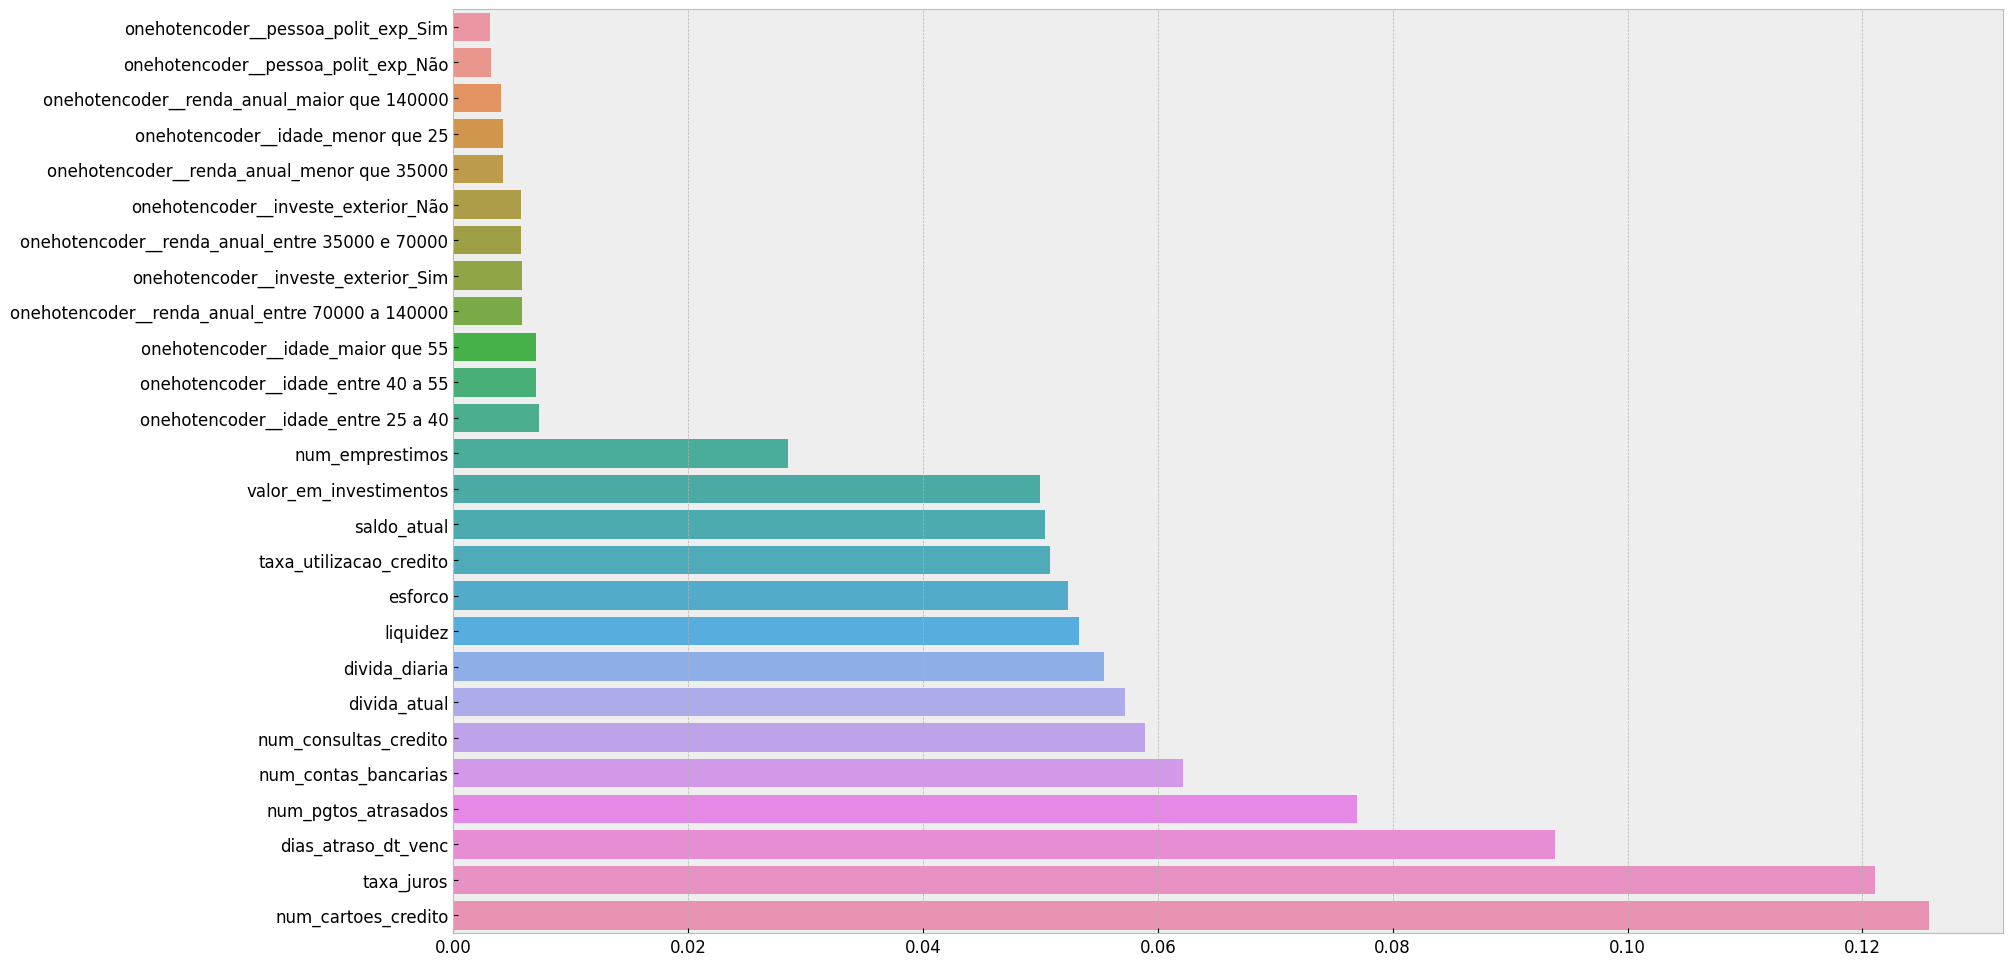

In [165]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500).fit(X_train, y_train)
feature_importance_sorted = rf.feature_importances_.argsort()
sns.barplot(y=rf.feature_names_in_[feature_importance_sorted], x=rf.feature_importances_[feature_importance_sorted] );
df_feature_importance_rf = pd.DataFrame( {'feature':rf.feature_names_in_[feature_importance_sorted], 'importance': rf.feature_importances_[feature_importance_sorted] } )
df_feature_importance_rf.sort_values(by='importance', ascending=False)

## Feature importance in a XGBoost

,feature,importance
25,taxa_juros,0.25
24,num_cartoes_credito,0.12
23,num_consultas_credito,0.09
22,dias_atraso_dt_venc,0.06
21,num_contas_bancarias,0.04
20,onehotencoder__renda_anual_entre 35000 e 70000,0.03
19,num_pgtos_atrasados,0.03
18,onehotencoder__renda_anual_maior que 140000,0.03
17,num_emprestimos,0.03
16,onehotencoder__idade_entre 40 a 55,0.03


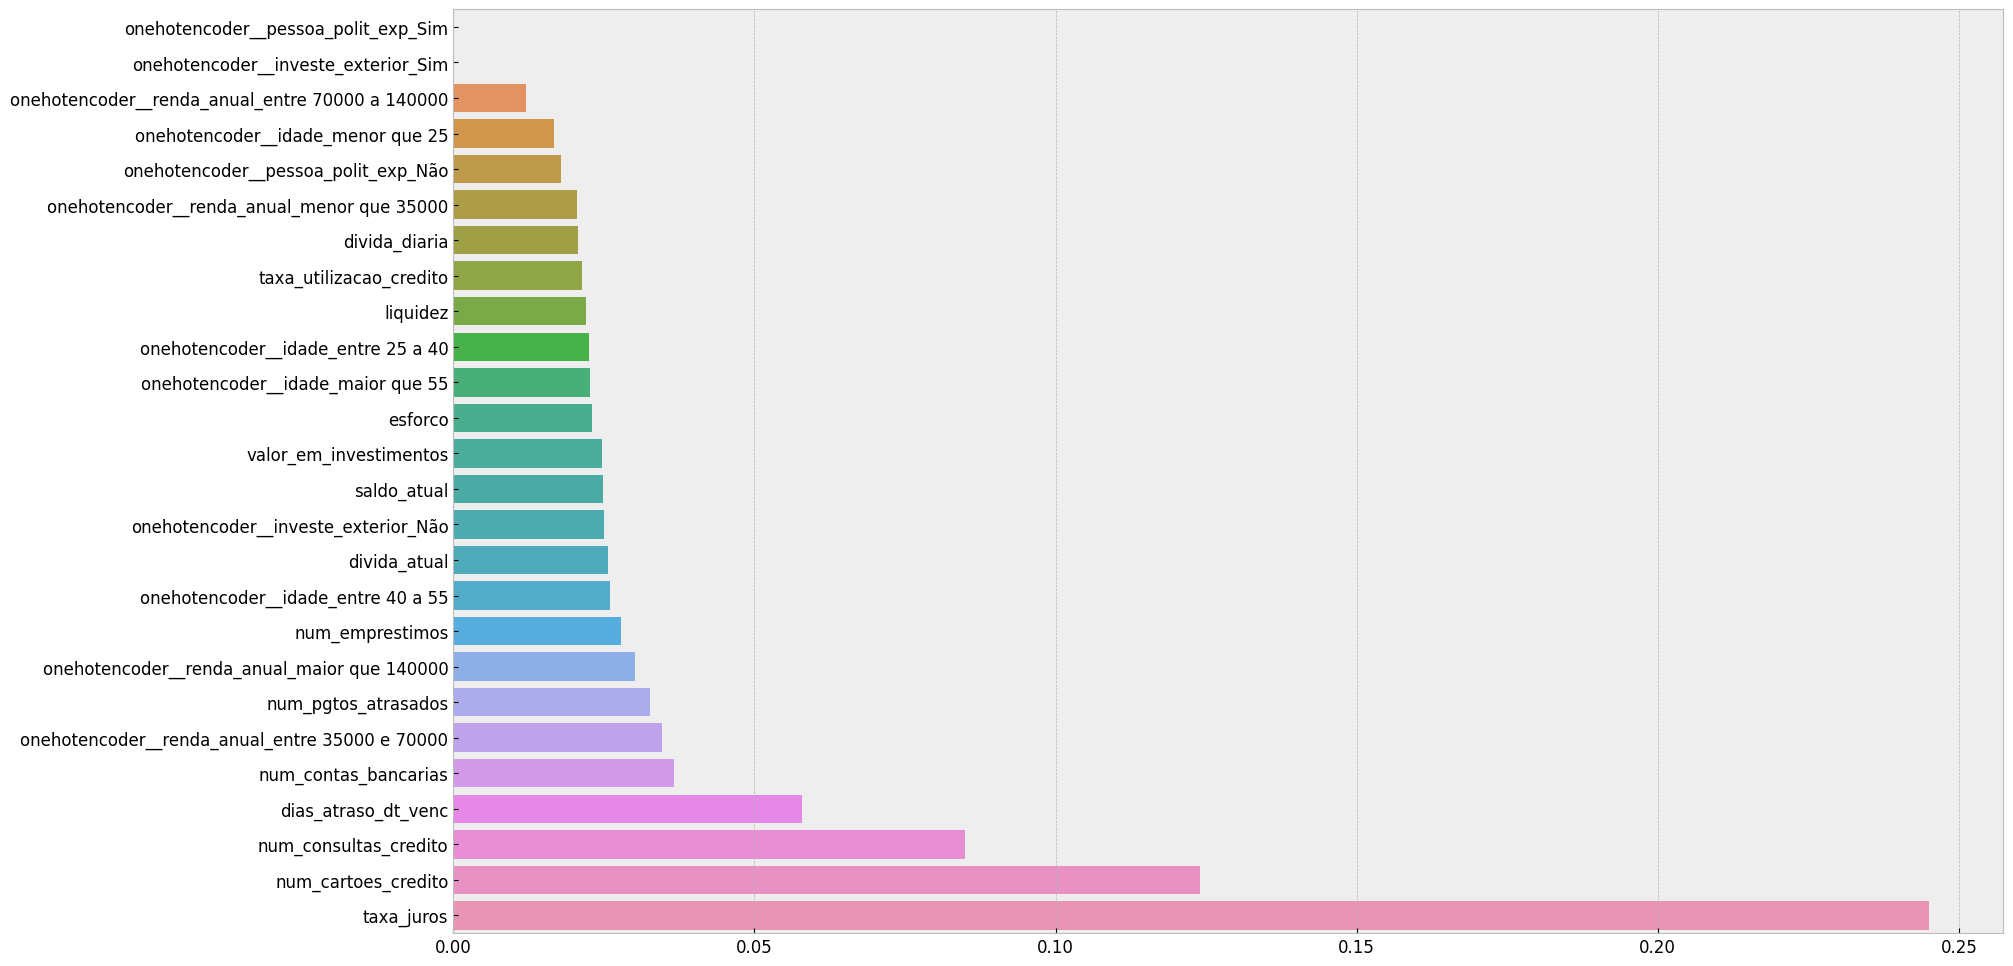

In [166]:
xgbc = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=500).fit(X_train, y_train)
feature_importance_sorted = xgbc.feature_importances_.argsort()
sns.barplot(y=xgbc.feature_names_in_[feature_importance_sorted], x=xgbc.feature_importances_[feature_importance_sorted] );
df_feature_importance_xgbc = pd.DataFrame( {'feature':xgbc.feature_names_in_[feature_importance_sorted], 'importance': xgbc.feature_importances_[feature_importance_sorted] } )
df_feature_importance_xgbc.sort_values(by='importance', ascending=False)

## Feature importance using permutation with XGBoost, Random Forest and Logistic Regression

In [167]:
columns_names = [X_validation.columns[i] for i in range(0,len(X_validation.columns) )]
rf= RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=200).fit(X_train, y_train)
xgbc= XGBClassifier(random_state=42,n_jobs=-1,n_estimators=200).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1).fit(X_train,y_train)

In [168]:
permutation_feature_rf = permutation_importance(rf, X_validation, y_validation, n_repeats=30, random_state=42,
                                        scoring={'f1_weighted': 'f1_weighted'})

In [169]:
permutation_feature_xgbc = permutation_importance(xgbc, X_validation, y_validation, n_repeats=30, random_state=42,
                                 scoring={'f1_weighted': 'f1_weighted'})

In [170]:
permutation_feature_knn = permutation_importance(knn, X_validation, y_validation, n_repeats=30, random_state=42,
                                 scoring={'f1_weighted': 'f1_weighted'})

In [171]:
importance_rf = pd.DataFrame({'features':columns_names,'F1':permutation_feature_rf['f1_weighted']['importances_mean']} ).sort_values(by='F1', ascending=False)
importance_rf

,features,F1
6,num_cartoes_credito,0.03
11,divida_diaria,0.01
12,liquidez,0.01
7,dias_atraso_dt_venc,0.01
8,num_pgtos_atrasados,0.01
2,valor_em_investimentos,0.00
0,saldo_atual,0.00
1,divida_atual,0.00
3,taxa_utilizacao_credito,0.00
22,onehotencoder__renda_anual_entre 35000 e 70000,0.00


In [173]:
importance_xgbc = pd.DataFrame({'features':columns_names, 
        'F1':permutation_feature_xgbc['f1_weighted']['importances_mean']} ).sort_values(by='F1', ascending=False)
importance_xgbc

,features,F1
6,num_cartoes_credito,0.02
0,saldo_atual,0.00
18,onehotencoder__idade_entre 25 a 40,0.00
3,taxa_utilizacao_credito,0.00
1,divida_atual,0.00
22,onehotencoder__renda_anual_entre 35000 e 70000,0.00
8,num_pgtos_atrasados,0.00
23,onehotencoder__renda_anual_entre 70000 a 140000,0.00
7,dias_atraso_dt_venc,0.00
2,valor_em_investimentos,0.00


In [174]:
importance_knn = pd.DataFrame({'features':columns_names, 
        'F1':permutation_feature_knn['f1_weighted']['importances_mean']} ).sort_values(by='F1', ascending=False)
importance_knn

,features,F1
7,dias_atraso_dt_venc,0.00
11,divida_diaria,0.00
10,taxa_juros,0.00
13,esforco,0.00
23,onehotencoder__renda_anual_entre 70000 a 140000,0.00
5,num_contas_bancarias,0.00
4,num_emprestimos,0.00
6,num_cartoes_credito,0.00
8,num_pgtos_atrasados,0.00
24,onehotencoder__renda_anual_maior que 140000,0.00


In [12]:
#cols_selected = ['num_cartoes_credito','taxa_juros','dias_atraso_dt_venc','num_pgtos_atrasados','num_consultas_credito','divida_atual']
x_train = X_train
x_val = X_validation

# Machine Learning Modelling

## Aproach using a threshold different of 0.5 and without balancing data

### Categorical Naive Bayes

In [176]:
sample_weights = compute_sample_weight(class_weight='balanced',  
                                    y=y_validation)

/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:275: RuntimeWarning: invalid value encountered in divide
  normalised = finals/finals.sum(axis=1, keepdims=True)


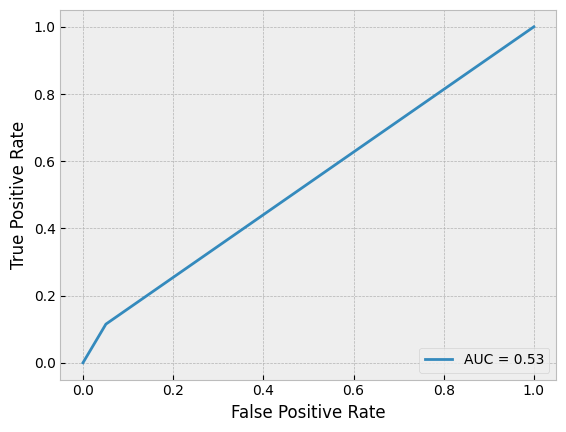

In [13]:
naive_bayes = MixedNB().fit(x_train, y_train)
y_predicted_bayes = naive_bayes.predict(x_val)
fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_predicted_bayes)
roc_auc = metrics.auc(fpr, tpr)
naive_roc = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
naive_roc.plot()

#### Naive Bayes Cross-validation

In [14]:
skf = StratifiedKFold(n_splits=10)
f1_naive = metrics.f1_score(y_validation,y_predicted_bayes, average='weighted')
naive_bayes_cv_f1 = []

for train_ix, test_ix in skf.split(x_train, y_train):
    X_train_cv, X_validation_cv = x_train.iloc[train_ix], x_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    naive_cv = MixedNB().fit(X_train_cv, y_train_cv)
    predictions = naive_cv.predict(X_validation_cv)
    naive_bayes_cv_f1.append( metrics.f1_score(y_validation_cv, predictions, average='weighted') )
    
naive_bayes_cv_mean_f1 = np.mean(naive_bayes_cv_f1)
naive_bayes_cv_std_f1 = np.std(naive_bayes_cv_f1 )
    
naive_bayes_cv_result = pd.DataFrame({'model_name':'naive_bayes','f1':f1_naive,'f1_cv': naive_bayes_cv_mean_f1,
                      'std_lift_cv':naive_bayes_cv_std_f1}, index=[0]) 
display(naive_bayes_cv_result)

/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:275: RuntimeWarning: invalid value encountered in divide
  normalised = finals/finals.sum(axis=1, keepdims=True)


,model_name,f1,f1_cv,std_lift_cv
0,naive_bayes,0.78,0.66,0.04


### Random Forest Classifier

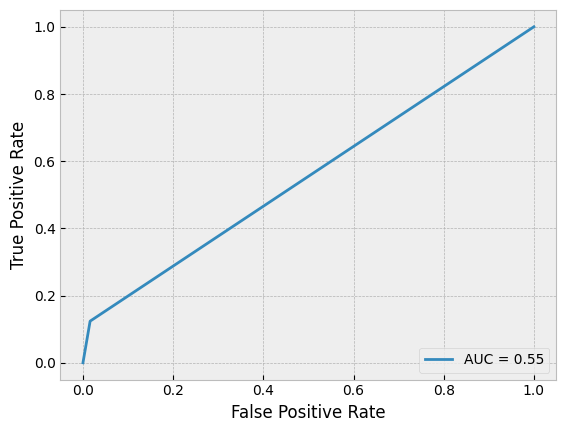

In [15]:
 rf= RandomForestClassifier(random_state=42,n_jobs=-1, n_estimators=500).fit(x_train, y_train)
y_proba_rf = rf.predict_proba(x_val)
y_predicted_rf = rf.predict(x_val)
fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_predicted_rf)
roc_auc_rf = metrics.auc(fpr, tpr)
rf_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_rf)
rf_plot.plot()

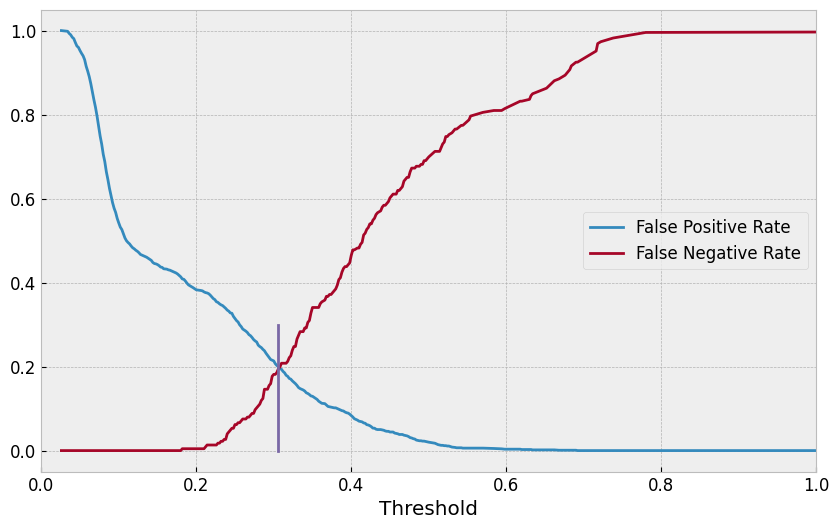

In [375]:
#Choose of threshhold
predtst_rf=rf.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_validation, predtst_rf)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
ax.plot([0.305,0.305],[0,0.3]) #mark example thresh.
ax.set_xbound(0,1)

#### Random Forest Cross-validation

In [16]:
lift_rf = metrics.f1_score(y_validation,y_predicted_rf, average='weighted')
skf = StratifiedKFold(n_splits=10)
rf_cv_lift = []
for train_ix, test_ix in skf.split(x_train, y_train):
    X_train_cv, X_validation_cv = x_train.iloc[train_ix], x_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    rf_cv = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=500 ).fit(X_train_cv, y_train_cv)
    predictions = rf_cv.predict(X_validation_cv)
    rf_cv_lift.append( metrics.f1_score(y_validation_cv, predictions, average='weighted') )

rf_cv_mean_lift  = np.mean(rf_cv_lift )
rf_cv_std_lift  = np.std(rf_cv_lift)
    
rf_cv_result = pd.DataFrame({'model_name':'random_forest','lift_score':lift_rf ,'lift_score_cv': rf_cv_mean_lift,
                      'std_lift_cv':rf_cv_std_lift}, index=[0]) 
display(rf_cv_result)

,model_name,lift_score,lift_score_cv,std_lift_cv
0,random_forest,0.80,0.87,0.01


### XGBoost Classifier

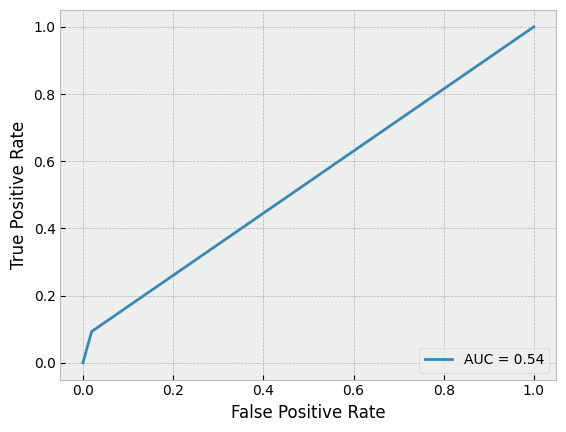

In [17]:
xgbc= XGBClassifier(random_state=42,n_jobs=-1,n_estimators=500).fit(x_train, y_train)
y_predicted_xgbc = xgbc.predict(x_val)
fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_predicted_xgbc)
roc_auc_xgbc= metrics.auc(fpr, tpr)
xgbc_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_xgbc)
xgbc_plot.plot()

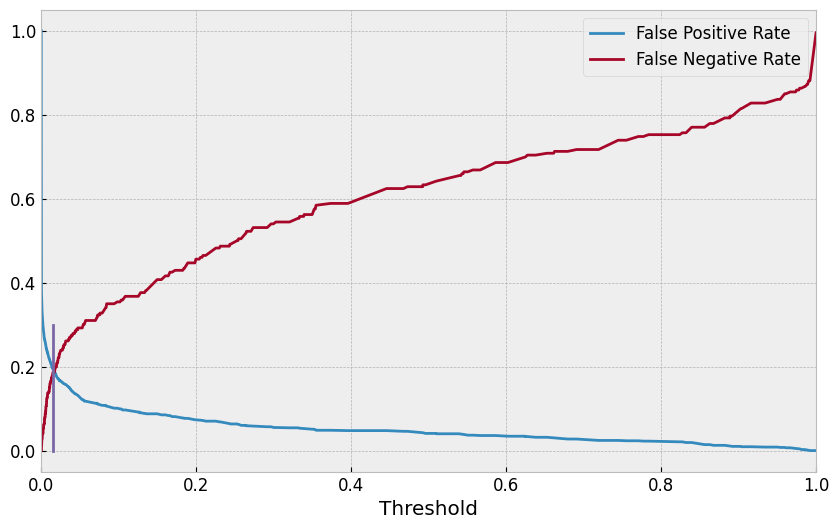

In [379]:
#Choose of threshhold
predtst_xgbc=xgbc.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_validation, predtst_xgbc)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
ax.plot([0.015,0.015],[0,0.3]) #mark example thresh.
ax.set_xbound(0,1)

#### XGBoost Cross-validation

In [18]:
lift_xgbc = metrics.f1_score(y_validation,y_predicted_xgbc,average='weighted')
skf = StratifiedKFold(n_splits=10)
xgbc_cv_lift = []
for train_ix, test_ix in skf.split(x_train, y_train):
    X_train_cv, X_validation_cv = x_train.iloc[train_ix], x_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    xgbc_cv = XGBClassifier(random_state=42,n_jobs=-1,n_estimators=200, ).fit(X_train_cv, y_train_cv)
    predictions = xgbc_cv.predict(X_validation_cv)
    xgbc_cv_lift.append( metrics.f1_score(y_validation_cv, predictions,average='weighted') )
    
xgbc_cv_mean_lift  = np.mean(xgbc_cv_lift )
xgbc_cv_std_lift  = np.std(xgbc_cv_lift )
    
xgbc_cv_result = pd.DataFrame({'model_name':'XGBoost','lift_score':lift_xgbc,'lift_score_cv': xgbc_cv_mean_lift,
                      'std_lift_cv':xgbc_cv_std_lift}, index=[0]) 
display(xgbc_cv_result)

,model_name,lift_score,lift_score_cv,std_lift_cv
0,XGBoost,0.79,0.86,0.01


### Model's Perfomance

In [20]:
df6 = X_validation.copy()
df6['response'] = y_validation.copy()

result = [f1_naive,lift_rf,lift_xgbc]
result_cv = [naive_bayes_cv_mean_f1,rf_cv_mean_lift,xgbc_cv_mean_lift]
model = ['naive_bayes','random_forest','XGBoost']
result_final = pd.DataFrame({'Model':model,'F1':result,'F1_cv':result_cv})

In [21]:
result_final

,Model,F1,F1_cv
0,naive_bayes,0.78,0.66
1,random_forest,0.80,0.87
2,XGBoost,0.79,0.86


In [33]:
#Dados de teste
# Carregar dataset teste
df_ktest_raw = pd.read_csv('test.csv')
x_ktest = df_ktest_raw.copy()

# Saldo devedor por dia (divida_atual / dias_atraso_dt_venc)
x_ktest['divida_diaria'] = x_ktest.apply(lambda x: x['divida_atual'] / x['dias_atraso_dt_venc'] if x['dias_atraso_dt_venc'] > 0 else 0, axis=1)

# Colocar dias de atraso menor que zero ser igual a 0.
x_ktest['dias_atraso_dt_venc'] = x_ktest['dias_atraso_dt_venc'].apply(lambda x: 0 if x < 0 else x)

# Liquidez (saldo_atual menos divida_atual)
x_ktest['liquidez'] = x_ktest.apply(lambda x: (x['divida_atual'] / x['saldo_atual']) * 100, axis=1)


# Esforço (divida atual / renda anual) Em percentual
x_ktest['esforco'] = x_ktest.apply(lambda x: (x['divida_atual'] / x['renda_anual']) * 100, axis=1)

#idade
x_ktest['idade'] = x_ktest['idade'].apply(lambda x: 'menor que 25' if x < 25 else 'entre 25 a 40' if 25 < x < 40 
                                 else 'entre 40 a 55' if 40 < x < 55 else 'maior que 55')

#renda anual
x_ktest['renda_anual'] = x_ktest['renda_anual'].apply(lambda x: 'menor que 35000' if x < 35000 else 'entre 35000 e 70000'
                                             if 35000 < x < 70000 else 'entre 70000 a 140000' if 70000 < x < 140000
                                             else 'maior que 140000')


In [34]:
# annual_premium - RobustScaler
x_ktest['saldo_atual'] = rs.transform(x_ktest[['saldo_atual']].values)
x_ktest['divida_atual'] = rs.transform(x_ktest[['divida_atual']].values)
x_ktest['valor_em_investimentos'] = rs.transform(x_ktest[['valor_em_investimentos']].values)
x_ktest['taxa_utilizacao_credito'] = rs.transform(x_ktest[['taxa_utilizacao_credito']].values)
x_ktest['num_emprestimos'] = rs.transform(x_ktest[['num_emprestimos']].values)
x_ktest['num_contas_bancarias'] = rs.transform(x_ktest[['num_contas_bancarias']].values)
x_ktest['num_cartoes_credito'] = rs.transform(x_ktest[['num_cartoes_credito']].values)
x_ktest['dias_atraso_dt_venc'] = rs.transform(x_ktest[['dias_atraso_dt_venc']].values)
x_ktest['num_pgtos_atrasados'] = rs.transform(x_ktest[['num_pgtos_atrasados']].values)
x_ktest['num_consultas_credito'] = rs.transform(x_ktest[['num_consultas_credito']].values)
x_ktest['taxa_juros'] = rs.transform(x_ktest[['taxa_juros']].values)
x_ktest['esforco'] = rs.transform(x_ktest[['esforco']].values)
x_ktest['liquidez'] = rs.transform(x_ktest[['liquidez']].values)
x_ktest['divida_diaria'] = rs.transform(x_ktest[['divida_diaria']].values)


#investe_exterior, pessoa_polit_exp - one hot encoding
transformed = transformer.transform(x_ktest)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out(), index=x_ktest.index)
x_ktest = pd.concat([x_ktest,transformed_df],axis=1).drop(['investe_exterior', 'pessoa_polit_exp','idade','renda_anual'], axis=1)

In [35]:
#XGBoost
yhat_xgboost_ktest = xgbc.predict(x_ktest.drop('id_cliente',axis=1))
df_sub = pd.concat([df_ktest_raw['id_cliente'], pd.Series(yhat_xgboost_ktest, name='limite_adicional')], axis=1)
lim_adi_dic_final = {0 : 'Negar', 1: 'Conceder'}
df_sub['limite_adicional'] = df_sub['limite_adicional'].map( lim_adi_dic_final )
df_sub.to_csv('submit_so_ano_que_vem.csv', index=False) 

In [37]:
#RF
yhat_rf_ktest = rf.predict(x_ktest.drop('id_cliente',axis=1))
df_sub = pd.concat([df_ktest_raw['id_cliente'], pd.Series(yhat_rf_ktest, name='limite_adicional')], axis=1)
lim_adi_dic_final = {0 : 'Negar', 1: 'Conceder'}
df_sub['limite_adicional'] = df_sub['limite_adicional'].map( lim_adi_dic_final )
df_sub.to_csv('submit_so_ano_que_vem.csv', index=False) 

In [401]:
#naive bayes
yhat_naive_ktest = naive_bayes.predict(x_ktest.drop('id_cliente',axis=1))
df_sub = pd.concat([df_ktest_raw['id_cliente'], pd.Series(yhat_naive_ktest, name='limite_adicional')], axis=1)
lim_adi_dic_final = {0 : 'Negar', 1: 'Conceder'}
df_sub['limite_adicional'] = df_sub['limite_adicional'].map( lim_adi_dic_final )
df_sub.to_csv('submit_so_ano_que_vem.csv', index=False) 

/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/mixed_naive_bayes/mixed_naive_bayes.py:275: RuntimeWarning: invalid value encountered in divide
  normalised = finals/finals.sum(axis=1, keepdims=True)


# Hyperparameter Fine Tuning

In [14]:
parameters = {
    'n_estimators': [800,1200,2000],
    'max_depth': [5,20,40,80,None],
    'min_samples_split': [2,10,20,40],
    'min_impurity_decrease': [0,.05,0.1]
}
skf = StratifiedKFold(n_splits=10)
rf_search =  BayesSearchCV(estimator=RandomForestClassifier(max_features='sqrt'), search_spaces=parameters, 
                           n_jobs=-1, cv=skf, scoring='f1_weighted', random_state=42)
rf_search_result = rf_search.fit(x_train,y_train)

/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/dbcordeiro/anaconda3/envs/insurance_cross-sell/lib

In [ ]:
parameters = {
    'n_estimators': [500,800,1200,1600,2200,3000],
    'learning_rate': [0.05,0.1,0.15],
    'max_depth': [10,20,40,80,None],
    'min_samples_split': [2,10,20,40,100],
    'min_impurity_decrease': [0,.05,.1],
    'colsample_bytree': [0.3,0.5,0.8],
    'subsample': [0.1,0.4,0.7]
}
skf = StratifiedKFold(n_splits=10)
rf_search =  BayesSearchCV(estimator=XGBClassifier(), search_spaces=parameters, 
                           n_jobs=-1, cv=skf, scoring='f1_weighted', random_state=42)
rf_search_result = rf_search.fit(x_train,y_train)